# Compile list of unique genes from intermediate_data_01

## Workflow

1. Loop through each dataset from `data/intermediate_data_01/`
2. For each dataset,
    - collect list of unique genes and associated candidate gene label
    - `included` =  the number of times the gene is assigned as candidate gene
    - `total_comparisons` = the number of comparisons (`fold_difference` or `protein_fold_difference`) for each gene. Computationally, this is the number of rows of data for that gene.
    - append `gene_id`, `included`, `total_comparisons`, `firstauthor_year` to dictionary `matches` or `mismatches` depending on whether the `gene_id` has a match in `ChlamydomonasTranscriptNameConversionBetweenReleases.Mch12b.txt`
3. Export `matches` and `mismatches` using `pickle`

In [1]:
import pandas as pd
import numpy as np
import os
import re
import warnings
import time
import pickle
import gzip
import re

## I. Essential functions

#### 1. Jump Search
`Jumpsearch` is a common search algorithm. The function below is modified from https://stackabuse.com/search-algorithms-in-python/  (accessed on May 19,2020). 

In [2]:
#test cell
import math

def JumpSearch (lys, val):
    
    '''This function returns the position of the element in the list lys that contains the string pattern lys. If no match 
    
    Usage: lys = list of strings to search through; val = string pattern to search for
    
    Warning: This function only works when the beginning of the string matches val'''
    
    length = len(lys)
    jump = int(math.sqrt(length))
    left, right = 0, 0
    index_list = sorted([lys[left],val,lys[right]])
    p = re.compile(re.escape(val))
    while left < length and index_list.index(lys[left]) <= index_list.index(val):
        right = min(length - 1, left + jump)
        index_list = sorted([lys[left],val,lys[right]])
        if index_list.index(lys[left]) <= index_list.index(val) and index_list.index(lys[right]) >= index_list.index(val):
            break
        left += jump;
        
    if left >= length or index_list.index(lys[left]) > index_list.index(val):
        return -1
    right = min(length-1, right)
    i = left
    #index_list = sorted([lys[i],val])
    while i <= right:
        index_list = sorted([lys[i],val])
        #print(p.search(lys[i]), lys[i])
        if p.match(lys[i]):
            return i
        i += 1
      
    return -1

##### Test `Jumpsearch`

In [3]:
#Generate sample list
file_path='/scratch/research/projects/chlamydomonas/lipid_selection/data/gene_name_conversion/ChlamydomonasTranscriptNameConversionBetweenReleases.Mch12b.txt.gz'
with gzip.open(file_path, "rt", encoding="utf-8") as z:
    conversion_key = pd.read_csv(z, delimiter = r"\s+",skiprows = 1, na_values = "--")
    conversion_key.columns = ['5.5', '3.1', 'Genbank', '4', '4.3', 'u5', 'u9', '5.3.1']
conversion_key = conversion_key[['5.5', genome_version ]].dropna()
#val = 'Cre01.g000300'
print(lys[20:31])


['Cre01.g001000.t1.2', 'Cre01.g001100.t1.1', 'Cre01.g001150.t1.2', 'Cre01.g001200.t1.2', 'Cre01.g001250.t1.1', 'Cre01.g001300.t1.2', 'Cre01.g001350.t1.1', 'Cre01.g001400.t1.1', 'Cre01.g001450.t1.1', 'Cre01.g001500.t1.1', 'Cre01.g001550.t1.2']


In [4]:
t0 = time.time()

#When value fully matches a string
val= 'Cre01.g001450.t1.1'
i = JumpSearch(lys , val)
print(i, lys[i])

#When value matches the beginning of a string
val= 'Cre01.g001450'
i = JumpSearch(lys , val)
print(i, lys[i])

#When value matches somewhere in the middle of a string
val='e01.g0014'
print(JumpSearch(lys , val))

#When value does not match any string
val= 'Bet you can\'t match this'
print(JumpSearch(lys , val))

t1= time.time()
total = t1-t0
print(total)  

28 Cre01.g001450.t1.1
28 Cre01.g001450.t1.1
-1
-1
0.0013446807861328125


#### Import datasets

In [5]:
current_dir = os.getcwd()
gene_info = pd.read_csv("../../data/intermediate_data_02/gene_info.csv", delimiter = ",")
basic_info = pd. read_csv("../../data/intermediate_data_01/basic_info.txt", delimiter='\t')
print(gene_info[:5])
print(basic_info[:5])

  transcript_identifier        gene_id gene_symbol              pathway_id  \
0    Cre01.g000300.t1.1  Cre01.g000300         NaN  Creinhardtii PWY0-1319   
1    Cre01.g000300.t1.1  Cre01.g000300         NaN   Creinhardtii PWY4FS-7   
2    Cre01.g000300.t1.1  Cre01.g000300         NaN   Creinhardtii PWY4FS-8   
3    Cre01.g000300.t1.1  Cre01.g000300         NaN   Creinhardtii PWY-5667   
4    Cre01.g000300.t1.1  Cre01.g000300         NaN   Creinhardtii PWY-7411   

  annotation_version  
0               v5.5  
1               v5.5  
2               v5.5  
3               v5.5  
4               v5.5  
  first_author  publication_year genome_version database_source  \
0     Bajhaiya              2016          5.3.1   Phytozome 9.1   
1        Blaby              2013            4.3  Augustus u10.2   
2        Boyle              2012            4.3  Augustus u10.2   
3     Gargouri              2015            5.5  Phytozyme 10.0   
4     Gargouri              2015            5.5  Phytozyme

## II. Match genes to `ChlamydomonasTranscriptNameConversionBetweenReleases.Mch12b.txt`

**Dictionary structure**

`matches = {'gene_id': { 'firstauthor_year:included:total' }`

`mismatches = {'gene_id': { 'firstauthor_year:included:total' }`

In [6]:
#test cell
matches = []
mismatches = []
match_summary = pd.DataFrame(columns = ["first_author", "year",'matches', 'mismatches', 'total'])
file_path='/scratch/research/projects/chlamydomonas/lipid_selection/data/gene_name_conversion/ChlamydomonasTranscriptNameConversionBetweenReleases.Mch12b.txt.gz'

os.chdir("../../data/intermediate_data_01/")
t0 = time.time()
count = 0
for file in os.listdir(os.getcwd()):
    #print(file)
    #if count>1: break
    #count+=1
    
    if file.endswith(".txt"):
        df = pd.read_csv(file, delimiter = "\t")
        total_genes, num_matches, num_mismatches, num_problems = [0]*4
    else: continue
    #if df['gene_id'].empty == False:
    #Loop through each unique gene in dataset
    if not ('gene_id' in list(df.columns)) or (file == "basic_info.txt"): 
        continue
    
    source = file.split(".")[0]
    first_author = source.split("_")[0]
    publication_year = int(source.split("_")[1])
    
    print(source)
    
    genome_version = str(list(basic_info[(basic_info['first_author']==first_author) & (basic_info['publication_year']==publication_year)].loc[:,'genome_version'])[0])
    print(genome_version, type(genome_version))
    
    with gzip.open(file_path, "rt", encoding="utf-8") as z:
        conversion_key = pd.read_csv(z, delimiter = r"\s+",skiprows = 1, na_values = "--")
        conversion_key.columns = ['5.5', '3.1', 'Genbank', '4', '4.3', 'u5', 'u9', '5.3.1']
        #conversion_key.rename(columns = {'5.5': "#5.5"})
        if genome_version != '5.5':
            try: 
                conversion_key = conversion_key[['5.5', genome_version ]]
                #print(conversion_key)
            except KeyError: print("Genome version not found!")
        if genome_version == '5.5':
            conversion_key = conversion_key[['5.5']]
        conversion_key = conversion_key.dropna().sort_values(by=[genome_version])
    
    included = list(df[['gene_id','candidate_gene']].groupby(['gene_id']).sum().astype(int).candidate_gene)
    gene = list(np.unique(df['gene_id']))
    total_comparisons = list(df['gene_id'].value_counts())
    total_genes = len(gene)
    #matches_temp = [conversion_key.iloc[matching_gene.index]['5.5'] for matching_gene in conversion_key[genome_version] if any(g in matching_gene for g in gene)]
    
    for i in range(total_genes):
  
    
    #Search for matching genes in key based on genome version
        
        search_output = JumpSearch(list(conversion_key[genome_version]), gene[i])
        
        if search_output == -1: 
            num_mismatches +=1
            
            #Generate output in dictionary format
            output = {'source': source, 'included': int(included[i]), 'total_comparisons': int(total_comparisons[i]), 'gene_id': gene[i]}
            mismatches.append(output)
        
        if search_output != -1:
            num_matches +=1
            
            #Generate output in dictionary format
            output = {'source': source, 'included': int(included[i]), 'total_comparisons': int(total_comparisons[i]), 'gene_id': list(conversion_key['5.5'])[search_output]}
            matches.append(output)
        
    if total_genes != num_matches+num_mismatches: 
        print(source, "genes did not add up")
        print(total_genes, num_matches, num_mismatches)
    
    match_summary = match_summary.append(pd.Series([first_author, publication_year, num_matches, num_mismatches, total_genes], 
                                                    index = match_summary.columns), 
                                            ignore_index=True)

matches = pd.DataFrame(matches)     
mismatches = pd.DataFrame(mismatches) 
        
t1= time.time()
total = t1-t0
print(total)        

Hemme_2014
4.3 <class 'str'>
Bajhaiya_2016
5.3.1 <class 'str'>
Goodenough_2014
4.3 <class 'str'>
Blaby_2013
4.3 <class 'str'>
Boyle_2012
4.3 <class 'str'>
Juergens_2015
5.3.1 <class 'str'>
Kwak_2017
5.5 <class 'str'>
Gargouri_2015
5.5 <class 'str'>
29.245651960372925


## Show summary of matches and mismatches

In [7]:
match_summary['proportion_of_matches'] = match_summary['matches']/match_summary['total']

In [8]:
print("Number of matches:", len(matches))
print(matches[:5])

print("Number of mismatches:", len(mismatches))
print(mismatches[:5])

#print("Number of Problems:", len(pd.unique(problems['gene_id'])))
#print (problems[:5])
print(match_summary)

Number of matches: 21671
              gene_id  included      source  total_comparisons
0  Cre01.g000350.t1.1         0  Hemme_2014                  1
1  Cre01.g000850.t1.2         0  Hemme_2014                  1
2  Cre01.g001100.t1.2         0  Hemme_2014                  1
3  Cre01.g001300.t1.1         0  Hemme_2014                  1
4  Cre01.g002300.t1.2         0  Hemme_2014                  1
Number of mismatches: 150
             gene_id  included      source  total_comparisons
0   Cre-1.g000035.t1         0  Hemme_2014                  2
1   Cre-1.g000040.t1         0  Hemme_2014                  2
2  Cre-1.g2716955.t1         0  Hemme_2014                  2
3  Cre-1.g2716958.t1         0  Hemme_2014                  2
4  Cre-1.g2716959.t1         0  Hemme_2014                  2
  first_author    year  matches  mismatches    total  proportion_of_matches
0        Hemme  2014.0   1894.0        86.0   1980.0               0.956566
1     Bajhaiya  2016.0  17736.0         1.0  17

## Export to intermediate_data_02

In [9]:
pickle_out = open("../../data/intermediate_data_02/matches", "wb")
pickle.dump(matches, pickle_out)
pickle_out.close()

pickle_out = open("../../data/intermediate_data_02/mismatches", "wb")
pickle.dump(mismatches, pickle_out)
pickle_out.close()

match_summary.to_csv("../../data/intermediate_data_02/match_summary.csv", index = False)


## Visualize summary

#### What is the distribution of matches among the papers?
- Is the proportion of matches related to year of publication?

Save figure output to `analysis/generate_intermediate_data_02/` folder

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
os.chdir(current_dir)

Index(['first_author', 'year', 'matches', 'mismatches', 'total',
       'proportion_of_matches'],
      dtype='object')
first_author              object
year                     float64
matches                  float64
mismatches               float64
total                    float64
proportion_of_matches    float64
dtype: object


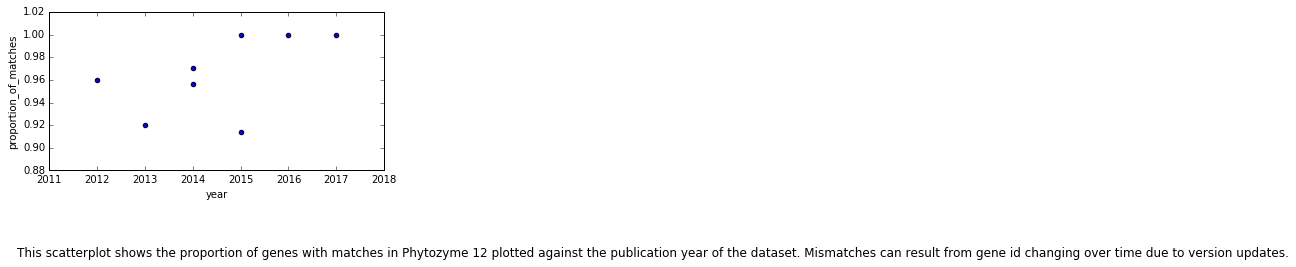

In [11]:
caption = "This scatterplot shows the proportion of genes with matches in Phytozyme 12 plotted against the publication year of the dataset. Mismatches can result from gene id changing over time due to version updates."

print(match_summary.columns)
match_summary['year'] = pd.to_numeric(match_summary['year'])
print(match_summary.dtypes)

fig = plt.figure()
match_summary.plot(x= 'year', y = 'proportion_of_matches', kind = "scatter")
plt.ticklabel_format(useOffset=False)
plt.subplots_adjust(bottom=0.35)
plt.figtext(0.05, 0.05,caption, fontsize=12, ha = 'left', wrap = True );

#Figure output is saved to analysis/generate_intermediate_data_02/ folder
plt.savefig("p_matches_versus_publication_year.png")